In [11]:
import os, sys
#sys.path.append(r'C:/Users/dg208')
sys.path.append(r'C:\Users\david\OneDrive\todo')
in_notebooks_dir = (
    (os.path.basename(os.getcwd()) == 'notebooks') and
    (os.path.exists(os.path.join(os.path.dirname(os.getcwd()), 'src')))
)
if in_notebooks_dir:
    os.chdir(os.path.dirname(os.getcwd()))

srcdir = os.path.join('..', 'src')
if srcdir not in sys.path:
    sys.path.insert(0, srcdir)

print(f" current folder is {os.getcwd()}")
%load_ext autoreload
%autoreload 2    



 current folder is c:\Users\david\OneDrive\todo\thresh_gacc
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from src import training_functions as tf

# import synthetic data

In [13]:
df = pd.read_pickle(r"data/synthetic_mnist_data.pkl")

In [14]:
df

,patient_id,roi,label,px_0,px_1,px_2,px_3,px_4,px_5,px_6,...,px_774,px_775,px_776,px_777,px_778,px_779,px_780,px_781,px_782,px_783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,38,8,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
338,38,9,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
339,39,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340,39,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# define ML pipeline

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV

from sklearn import set_config
set_config(enable_metadata_routing=True)

In [19]:
cv_holdout = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, test_idx =  next(cv_holdout.split(df, df["label"], df["patient_id"]))

In [34]:
df.columns

Index(['patient_id', 'roi', 'label', 'px_0', 'px_1', 'px_2', 'px_3', 'px_4',
       'px_5', 'px_6',
       ...
       'px_774', 'px_775', 'px_776', 'px_777', 'px_778', 'px_779', 'px_780',
       'px_781', 'px_782', 'px_783'],
      dtype='object', length=787)

In [48]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),
    ('svc', SVC(kernel='rbf'))
])
param_grid = {
    'svc__C': np.logspace(-1, 6, 7),
    'svc__gamma': np.logspace(-6, -2, 4)
}
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
scorer = tf.tresh_gacc_scorer(cutoff=0.5)
grid_search = GridSearchCV(
    pipe, param_grid, cv=cv, scoring=scorer, n_jobs=1, refit=True
)

X_train = np.stack(df.loc[train_idx, 'px_0':'px_783'].values)
y_train = df.loc[train_idx, 'label'].values
groups_train = df.loc[train_idx, 'patient_id'].values
X_test = np.stack(df.loc[test_idx, 'px_0':'px_783'].values)
y_test = df.loc[test_idx, 'label'].values
groups_test = df.loc[test_idx, 'patient_id'].values
grid_search.fit(X_train, y_train, groups=groups_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Best parameters: {'svc__C': np.float64(316.22776601683796), 'svc__gamma': np.float64(0.00046415888336127773)}
Best cross-validation score: 0.9048


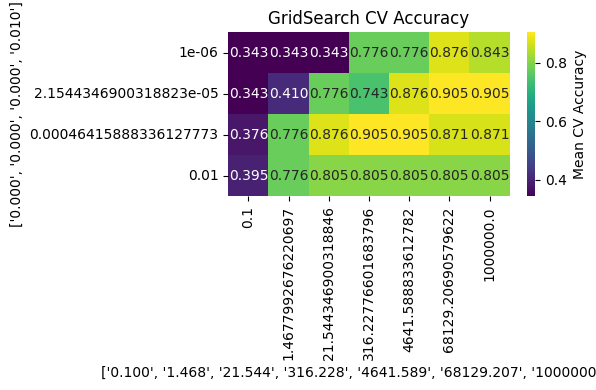

In [51]:
plot_gridsearch_heatmap(grid_search)

ValueError: Unknown format code 'f' for object of type 'str'

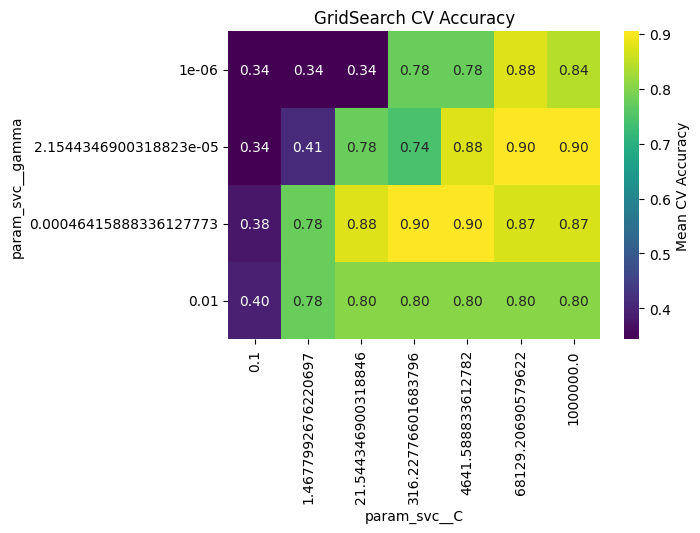

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_gridsearch_heatmap(grid_search, param_x='svc__C', param_y='svc__gamma'):
    results = pd.DataFrame(grid_search.cv_results_)
    
    pivot = results.pivot_table(
        index=f'param_{param_y}',
        columns=f'param_{param_x}',
        values='mean_test_score'
    )
    
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(
        pivot,
        annot=True,
        fmt='.2f',
        cmap='viridis',
        ax=ax,
        cbar_kws={'label': 'Mean CV Accuracy'}
    )
    ax.set_title('GridSearch CV Accuracy')
    ax.set_xlabel(param_x)
    ax.set_ylabel(param_y)
    ax.set_xticklabels([f'{float(x.get_text()):.2f}' for x in ax.get_xticklabels()])
    ax.set_yticklabels([f'{float(y.get_text()):.2f}' for y in ax.get_yticklabels()])
    plt.tight_layout()
    plt.show()

# Usage:
plot_gridsearch_heatmap(grid_search)

# merge data tables (elpis imaging list & tma imaging list)

### get combined elpis and georgia list

In [91]:
folder = "W:\\Data\\CutaneousMelanoma\\sample_set_Elpis"
df_elpis = mel.get_elpis(
    Path(folder) / r"elpis_imaging_list.xlsx",
    Path(folder) / r"georgia_biorep.xlsx",
    melanoma_only=False
    )
df_elpis['location'] = "primary"
df_elpis.drop(
    columns=[
        'comments', 'hair', 'epidermis', 'below\nepidermis', 'both', 'unclear'
        ],
    inplace=True,
    )


### TMA

In [131]:
folder = "W:\\Data\\CutaneousMelanoma\\sample_set_TMA\\"
df_tma = pd.read_excel(folder + "tma_imaging_list.xlsx", sheet_name=2)
# drop useless columns
df_tma = df_tma.drop(columns=["stitched", "comments"])

# add evaluation folder, label, melanoma etc
df_tma["folder_eva"] = df_tma["folder"] + "_evaluation"
df_tma["location"] = "metastasis"
df_tma["melanoma"] = 1
df_tma["control"] = 0
df_tma["mask manual slices"] = None

# create unique sample identifier based on tma and continent/ROI
def unique_identifier(row):
    slide_name = re.search(
        "(^tma[1-9])_[1-9]$", row["sample identifier"]
    ).group(1)
    patient = re.search(
        "(^P[0-9]{2})-ROI[0-9]{2}", row["continent/ROI"]
    ).group(1)
    return slide_name + "-" + patient

df_tma["sample identifier"] = df_tma.apply(unique_identifier, axis=1)
df_tma.head()

,sample identifier,continent/ROI,folder,filename,pre-imaging folder,folder_eva,location,melanoma,control,mask manual slices
0,tma1-P01,P01-ROI01,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,tma1_1_P01-ROI01_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_TMA\00_pr...,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,metastasis,1,0,None
1,tma1-P01,P01-ROI02,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,tma1_1_P01-ROI02_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_TMA\00_pr...,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,metastasis,1,0,None
2,tma1-P01,P01-ROI03,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,tma1_1_P01-ROI03_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_TMA\00_pr...,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,metastasis,1,0,None
3,tma1-P01,P01-ROI04,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,tma1_1_P01-ROI04_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_TMA\00_pr...,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,metastasis,1,0,None
4,tma1-P02,P02-ROI01,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,tma1_1_P02-ROI01_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_TMA\00_pr...,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,metastasis,1,0,None


### combine TMA and elpis

In [132]:
df = pd.concat([df_elpis, df_tma], ignore_index=True)

# fit xcorr measurements

In [133]:
df["xcorr filename"] = df.apply(create_avg_ta.find_xcorr, axis=1)

In [134]:
df["pulse width"] = df.apply(lambda x: fit_xcorr(x["xcorr filename"][0]), axis=1)

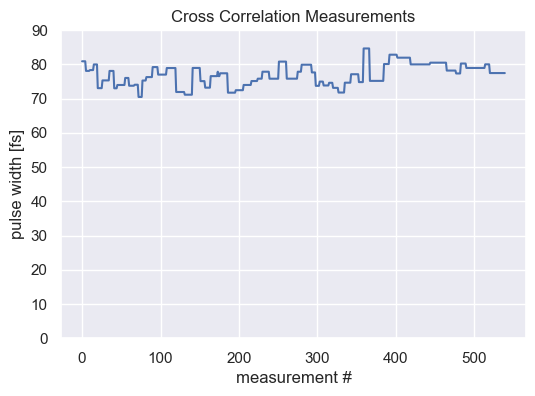

In [135]:
sns.set_theme()
figure, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(df["pulse width"]*1000)
ax.set_xlabel("measurement #")
ax.set_ylabel("pulse width [fs]")
ax.set_ylim(0, 90)
ax.set_title("Cross Correlation Measurements")
plt.show()

# compute avg TA curver per ROI

## preProcessed 01
Note that "preProcessed_01_sf5_li_threshold_1.2.pickle" was created with routines in folders
* elpis pre-processing: W:\Data\CutaneousMelanoma\sample_set_Elpis\12_pheme_770_730_python
* TMA pre-processing: W:\Data\CutaneousMelanoma\sample_set_TMA\01_770_730_pre_processing

I fittet the true 0 offset for every ROI already in the past, i.e. see OneNote W2 Cutaneous Melanoma/Metastatic Potential/770-730 approach/TMA/Melanin benign versus metastatic. The procedure can be found in folder W:\Data\CutaneousMelanoma\melanin_comparison(old)\obsolete\approach01_20250730 in notebook 20250729_time_offset_estimation.ipynb
The results were saved as "20250730_metadata_fitting.pickle" and I import them here to merge them with the avg ta DataFrame


In [11]:
folder = r"W:\Data\CutaneousMelanoma\melanin_comparison(old)\obsolete\approach01_20250730"
df_offset = pd.read_pickle(
    os.path.join(folder, "20250730_metadata_fitting.pickle")
    )

In [12]:
df_offset

,sample identifier,continent/ROI,folder,filename,pre-imaging folder,melanoma,control,outside,hair,epidermis,location,folder_eva,xcorr filename,pulse width,t0
0,N270,1_C01-ROI01,W:\Data\CutaneousMelanoma\sample_set_Elpis\N27...,elpis_N270_1_C01-ROI01_770_730_0.3_0.3_stich_D...,W:\Data\CutaneousMelanoma\sample_set_Elpis\03_...,0.0,1.0,0.0,0.0,1.0,control,W:\Data\CutaneousMelanoma\sample_set_Elpis\N27...,[W:\Data\CutaneousMelanoma\sample_set_Elpis\N2...,0.080932,0.029723
1,N270,1_C01-ROI02,W:\Data\CutaneousMelanoma\sample_set_Elpis\N27...,elpis_N270_1_C01-ROI02_770_730_0.3_0.3_stich_D...,W:\Data\CutaneousMelanoma\sample_set_Elpis\03_...,0.0,1.0,0.0,0.0,1.0,control,W:\Data\CutaneousMelanoma\sample_set_Elpis\N27...,[W:\Data\CutaneousMelanoma\sample_set_Elpis\N2...,0.080932,0.020960
2,N270,1_C01-ROI03,W:\Data\CutaneousMelanoma\sample_set_Elpis\N27...,elpis_N270_1_C01-ROI03_770_730_0.3_0.3_stich_D...,W:\Data\CutaneousMelanoma\sample_set_Elpis\03_...,1.0,0.0,0.0,0.0,1.0,primary,W:\Data\CutaneousMelanoma\sample_set_Elpis\N27...,[W:\Data\CutaneousMelanoma\sample_set_Elpis\N2...,0.080932,0.014633
3,N270,1_C01-ROI04,W:\Data\CutaneousMelanoma\sample_set_Elpis\N27...,elpis_N270_1_C01-ROI04_770_730_0.3_0.3_stich_D...,W:\Data\CutaneousMelanoma\sample_set_Elpis\03_...,1.0,0.0,0.0,0.0,0.0,primary,W:\Data\CutaneousMelanoma\sample_set_Elpis\N27...,[W:\Data\CutaneousMelanoma\sample_set_Elpis\N2...,0.080932,0.014061
4,N270,1_C01-ROI05,W:\Data\CutaneousMelanoma\sample_set_Elpis\N27...,elpis_N270_1_C01-ROI05_770_730_0.3_0.3_stich_D...,W:\Data\CutaneousMelanoma\sample_set_Elpis\03_...,1.0,0.0,0.0,0.0,0.0,primary,W:\Data\CutaneousMelanoma\sample_set_Elpis\N27...,[W:\Data\CutaneousMelanoma\sample_set_Elpis\N2...,0.080932,0.011606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,tma1-P17,P17-ROI02,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,tma1_1_P17-ROI02_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_TMA\00_pr...,1.0,0.0,NaN,NaN,NaN,metastasis,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,[W:\Data\CutaneousMelanoma\sample_set_TMA\00_p...,0.077489,0.001627
536,tma1-P17,P17-ROI03,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,tma1_1_P17-ROI03_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_TMA\00_pr...,1.0,0.0,NaN,NaN,NaN,metastasis,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,[W:\Data\CutaneousMelanoma\sample_set_TMA\00_p...,0.077489,0.009421
537,tma1-P18,P18-ROI01,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,tma1_1_P18-ROI01_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_TMA\00_pr...,1.0,0.0,NaN,NaN,NaN,metastasis,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,[W:\Data\CutaneousMelanoma\sample_set_TMA\00_p...,0.077489,-0.007920
538,tma1-P18,P18-ROI02,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,tma1_1_P18-ROI02_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_TMA\00_pr...,1.0,0.0,NaN,NaN,NaN,metastasis,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,[W:\Data\CutaneousMelanoma\sample_set_TMA\00_p...,0.077489,-0.010013


In [13]:
df = df.merge(
    df_offset[["sample identifier", "continent/ROI", "t0"]],
    on=["sample identifier", "continent/ROI"],
    how="left"
    )

In [14]:
df

,sample identifier,continent/ROI,folder,filename,pre-imaging folder,melanoma,control,outside,hair,epidermis,location,folder_eva,recurrence,SLNB,xcorr filename,pulse width,t0
0,N270,1_C01-ROI01,W:\Data\CutaneousMelanoma\sample_set_Elpis\N27...,elpis_N270_1_C01-ROI01_770_730_0.3_0.3_stich_D...,W:\Data\CutaneousMelanoma\sample_set_Elpis\03_...,0.0,1.0,0.0,0.0,1.0,control,W:\Data\CutaneousMelanoma\sample_set_Elpis\N27...,1.0,0.0,[W:\Data\CutaneousMelanoma\sample_set_Elpis\N2...,0.080932,0.029723
1,N270,1_C01-ROI02,W:\Data\CutaneousMelanoma\sample_set_Elpis\N27...,elpis_N270_1_C01-ROI02_770_730_0.3_0.3_stich_D...,W:\Data\CutaneousMelanoma\sample_set_Elpis\03_...,0.0,1.0,0.0,0.0,1.0,control,W:\Data\CutaneousMelanoma\sample_set_Elpis\N27...,1.0,0.0,[W:\Data\CutaneousMelanoma\sample_set_Elpis\N2...,0.080932,0.020960
2,N270,1_C01-ROI03,W:\Data\CutaneousMelanoma\sample_set_Elpis\N27...,elpis_N270_1_C01-ROI03_770_730_0.3_0.3_stich_D...,W:\Data\CutaneousMelanoma\sample_set_Elpis\03_...,1.0,0.0,0.0,0.0,1.0,primary,W:\Data\CutaneousMelanoma\sample_set_Elpis\N27...,1.0,0.0,[W:\Data\CutaneousMelanoma\sample_set_Elpis\N2...,0.080932,0.014633
3,N270,1_C01-ROI04,W:\Data\CutaneousMelanoma\sample_set_Elpis\N27...,elpis_N270_1_C01-ROI04_770_730_0.3_0.3_stich_D...,W:\Data\CutaneousMelanoma\sample_set_Elpis\03_...,1.0,0.0,0.0,0.0,0.0,primary,W:\Data\CutaneousMelanoma\sample_set_Elpis\N27...,1.0,0.0,[W:\Data\CutaneousMelanoma\sample_set_Elpis\N2...,0.080932,0.014061
4,N270,1_C01-ROI05,W:\Data\CutaneousMelanoma\sample_set_Elpis\N27...,elpis_N270_1_C01-ROI05_770_730_0.3_0.3_stich_D...,W:\Data\CutaneousMelanoma\sample_set_Elpis\03_...,1.0,0.0,0.0,0.0,0.0,primary,W:\Data\CutaneousMelanoma\sample_set_Elpis\N27...,1.0,0.0,[W:\Data\CutaneousMelanoma\sample_set_Elpis\N2...,0.080932,0.011606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,tma1-P17,P17-ROI02,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,tma1_1_P17-ROI02_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_TMA\00_pr...,1.0,0.0,NaN,NaN,NaN,metastasis,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,NaN,NaN,[W:\Data\CutaneousMelanoma\sample_set_TMA\00_p...,0.077489,0.001627
536,tma1-P17,P17-ROI03,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,tma1_1_P17-ROI03_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_TMA\00_pr...,1.0,0.0,NaN,NaN,NaN,metastasis,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,NaN,NaN,[W:\Data\CutaneousMelanoma\sample_set_TMA\00_p...,0.077489,0.009421
537,tma1-P18,P18-ROI01,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,tma1_1_P18-ROI01_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_TMA\00_pr...,1.0,0.0,NaN,NaN,NaN,metastasis,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,NaN,NaN,[W:\Data\CutaneousMelanoma\sample_set_TMA\00_p...,0.077489,-0.007920
538,tma1-P18,P18-ROI02,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,tma1_1_P18-ROI02_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_TMA\00_pr...,1.0,0.0,NaN,NaN,NaN,metastasis,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,NaN,NaN,[W:\Data\CutaneousMelanoma\sample_set_TMA\00_p...,0.077489,-0.010013


In [15]:
fn_pre_processed = "preProcessed_01_sf5_li_threshold_1.2.pickle"
base_name = "preprocessed_01"

if not os.path.exists(os.path.join("data/processed", base_name)):
    os.mkdir(os.path.join("data/processed", base_name))

for i in [-1, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]:
    result = df.apply(
        create_avg_ta.avg_ta,
        axis=1,
        args=(fn_pre_processed, i)
    )
    result = pd.concat(result.to_list(), ignore_index=True)

    # create filename 
    if i == -1:
        filename = os.path.join(
            "data/processed",
            base_name,
            "melanin_df_size-1_" + base_name + ".pickle"
            )
    else:
        filename = os.path.join(
            "data/processed",
              base_name, 
              f"melanin_df_size{i:04}_" + base_name + ".pickle"
              )   
    result.to_pickle(filename)
    print("done with size:", f"{i:04}")

done with size: -001
done with size: 0050
done with size: 0075
done with size: 0100
done with size: 0125
done with size: 0150
done with size: 0175
done with size: 0200
done with size: 0225
done with size: 0250
done with size: 0275
done with size: 0300


# preprocessed 2

In [137]:
def average_ta_curve(row, threshold, size):
    # preprocessing and manual mask
    fn = Path(row["folder"]) / row['filename']
    stack = PPS(fn, dataType='DukeScan').subtractFirst(5).downsample(2)
    stack.mask_slices(row['mask manual slices'])
    stack = stack.intensity_threshold(threshold)

    curves = PPS.avg_ta(stack, size, cutoff=50, norm='minmax')

    df = pd.DataFrame(
            [pd.concat([row, pd.Series(i, index=stack.times)]) for i in curves]
        )
    return df

In [ ]:
fn_pre_processed = "preProcessed_02_sf5_li_threshold_1.4.pickle"
base_name = "preprocessed_02"


if not os.path.exists(os.path.join("data/processed", base_name)):
    os.mkdir(os.path.join("data/processed", base_name))

for size in [-1, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]:
    result = pd.concat(
        df.apply(
            lambda row: average_ta_curve(row, threshold=1.4, size=size),
            axis=1
        ).to_list(),
        ignore_index=True
    )
    
    filename = os.path.join(
            "data/processed",
              base_name, 
              f"melanin_df_size{size:04}_" + base_name + ".pickle"
              )
    result.to_pickle(filename)
    print("done with size:", f"{size:04}")

c:\Users\dg208\melanin_comparison\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\dg208\melanin_comparison\venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\dg208\melanin_comparison\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\dg208\melanin_comparison\venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


done with size: -001


In [130]:
df[481:]

,sample identifier,continent/ROI,folder,filename,pre-imaging folder,melanoma,control,outside,folder_eva,mask manual slices,recurrence,SLNB,location,xcorr filename,pulse width
481,N335,1_C01-ROI01,W:\Data\CutaneousMelanoma\sample_set_Elpis\N33...,elpis_N335_1_C01-ROI01_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_Elpis\03_...,1.0,NaN,NaN,W:\Data\CutaneousMelanoma\sample_set_Elpis\N33...,None,0.0,0.0,primary,[W:\Data\CutaneousMelanoma\sample_set_Elpis\03...,0.077371
482,N335,1_C01-ROI02,W:\Data\CutaneousMelanoma\sample_set_Elpis\N33...,elpis_N335_1_C01-ROI02_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_Elpis\03_...,1.0,NaN,NaN,W:\Data\CutaneousMelanoma\sample_set_Elpis\N33...,"[(slice(0, 19, None), slice(0, 17, None))]",0.0,0.0,primary,[W:\Data\CutaneousMelanoma\sample_set_Elpis\03...,0.077371
483,tma1-P01,P01-ROI01,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,tma1_1_P01-ROI01_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_TMA\00_pr...,1.0,0.0,NaN,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,NaN,NaN,NaN,metastasis,[W:\Data\CutaneousMelanoma\sample_set_TMA\00_p...,0.080277
484,tma1-P01,P01-ROI02,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,tma1_1_P01-ROI02_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_TMA\00_pr...,1.0,0.0,NaN,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,NaN,NaN,NaN,metastasis,[W:\Data\CutaneousMelanoma\sample_set_TMA\00_p...,0.080277
485,tma1-P01,P01-ROI03,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,tma1_1_P01-ROI03_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_TMA\00_pr...,1.0,0.0,NaN,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,NaN,NaN,NaN,metastasis,[W:\Data\CutaneousMelanoma\sample_set_TMA\00_p...,0.080277
486,tma1-P01,P01-ROI04,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,tma1_1_P01-ROI04_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_TMA\00_pr...,1.0,0.0,NaN,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,NaN,NaN,NaN,metastasis,[W:\Data\CutaneousMelanoma\sample_set_TMA\00_p...,0.080277
487,tma1-P02,P02-ROI01,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,tma1_1_P02-ROI01_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_TMA\00_pr...,1.0,0.0,NaN,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,NaN,NaN,NaN,metastasis,[W:\Data\CutaneousMelanoma\sample_set_TMA\00_p...,0.080277
488,tma1-P02,P02-ROI02,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,tma1_1_P02-ROI02_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_TMA\00_pr...,1.0,0.0,NaN,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,NaN,NaN,NaN,metastasis,[W:\Data\CutaneousMelanoma\sample_set_TMA\00_p...,0.080277
489,tma1-P02,P02-ROI03,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,tma1_1_P02-ROI03_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_TMA\00_pr...,1.0,0.0,NaN,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,NaN,NaN,NaN,metastasis,[W:\Data\CutaneousMelanoma\sample_set_TMA\00_p...,0.080277
490,tma1-P03,P03-ROI01,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,tma1_1_P03-ROI01_770_730_0.3_0.3_DS_CH1.tif,W:\Data\CutaneousMelanoma\sample_set_TMA\00_pr...,1.0,0.0,NaN,W:\Data\CutaneousMelanoma\sample_set_TMA\TMA1\...,NaN,NaN,NaN,metastasis,[W:\Data\CutaneousMelanoma\sample_set_TMA\00_p...,0.078980
